In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests

from functions import *
from tqdm import tqdm


# API call

In [20]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["10", "199", "299", "399", "301", "499", "599", "699", "799", "899"]  # sun, mercury, venus, earth, moon, mars, jupiter, saturn, uranus, neptun
target_names = ["sun", "mercury", "venus", "earth", "moon", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='1800-01-01'"
stop = "STOP_TIME='2023-01-01'"
step = "STEP_SIZE='1 d'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
units = "OUT_UNITS='AU-D'"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [21]:
data = []
time = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format+"&"+units
    q, p, t = read_data(requests.get(path).text)
    data.append([[q], [p]])
    time.append([t])
    
data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))
time = np.asarray(time).reshape((len(targets),len(time[0][0])))

In [22]:
print(data.shape)

(10, 2, 81450, 3)


## Data shape

10 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

# Phase spaces for all bodies in the system

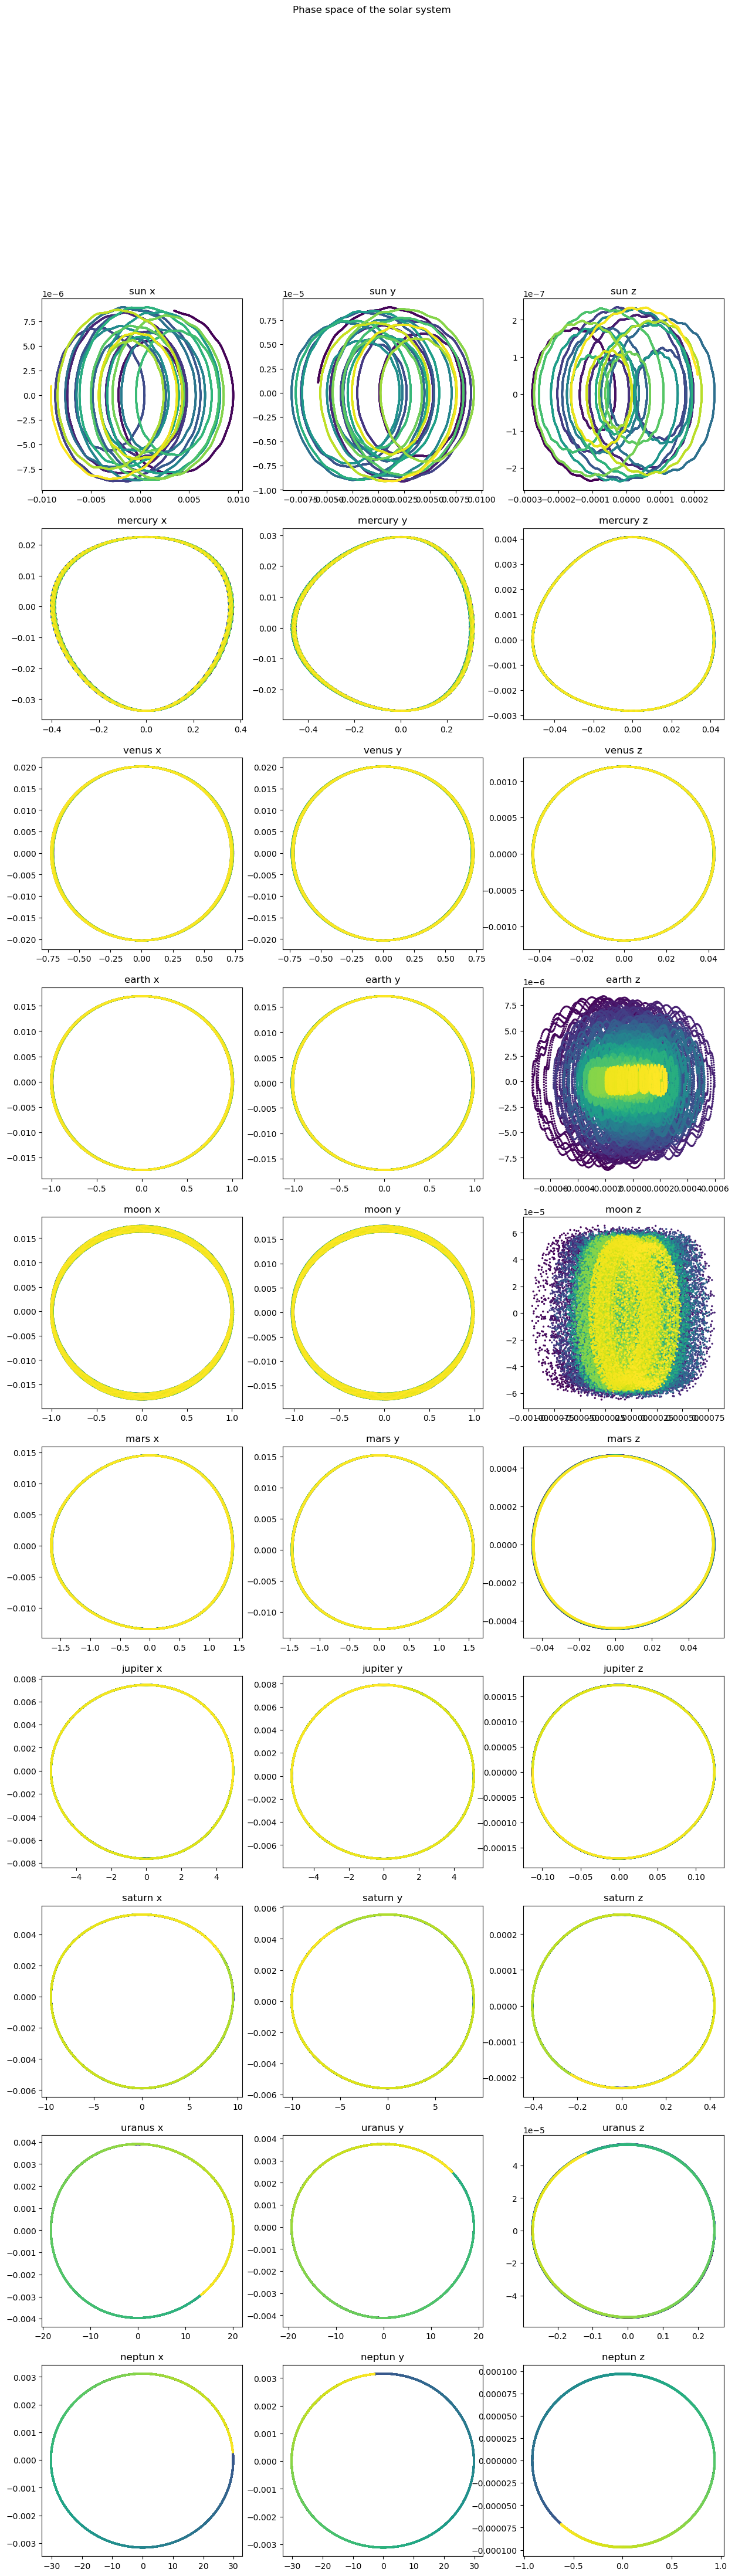

In [23]:
plot_phase_space(data, target_names, "Phase space of the solar system")

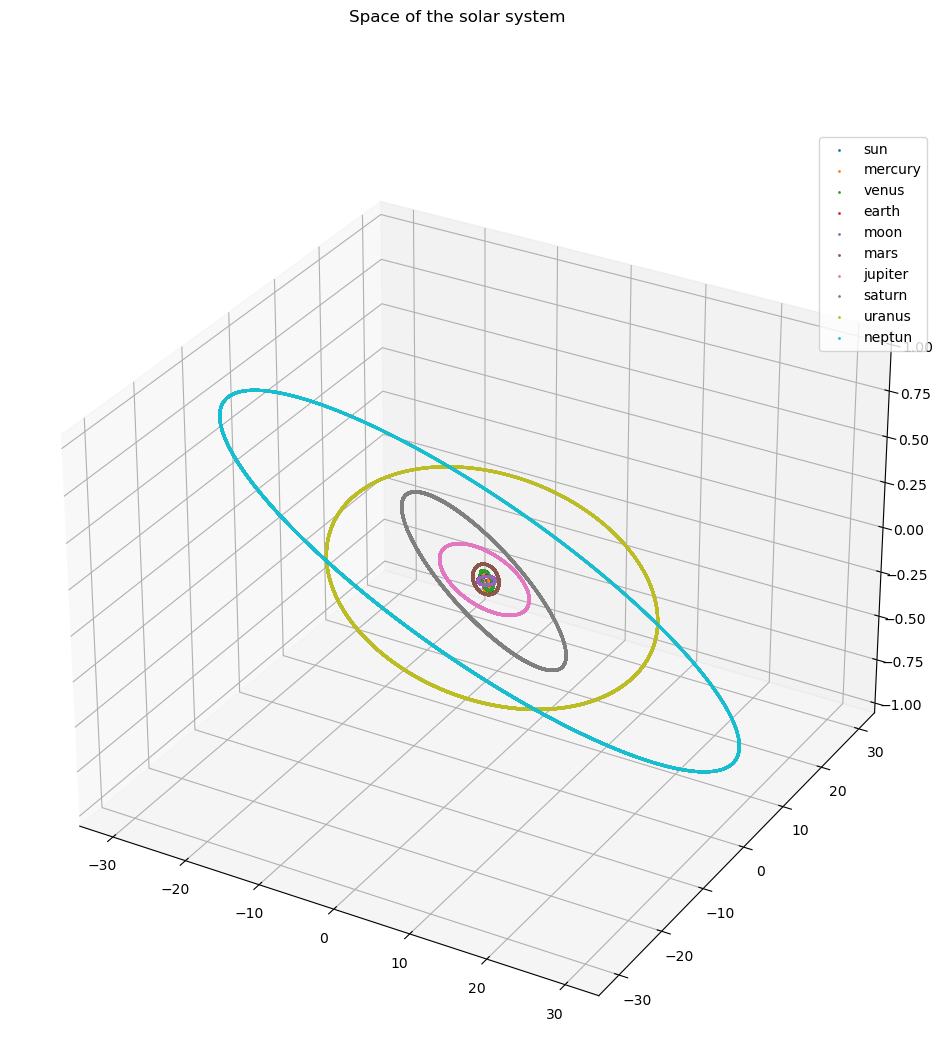

In [24]:
plot_space(data, target_names, "Space of the solar system")

# Learning the solar system

## Preparing the data

In [25]:
q, dq, p, dp = prep_data(data, time)

q_p = np.concatenate((q, p), axis=1)
q_p = torch.tensor(q_p, requires_grad=True, dtype=torch.float32)

dq_dp = np.concatenate((dq, dp), axis=1)
dq_dp = torch.tensor(dq_dp, requires_grad=True, dtype=torch.float32)

## Normal Neural Network

In [26]:
class MLP(nn.Module):
    def __init__(self, bodys) -> None:
        super().__init__()

        self.fc1 = nn.Linear(bodys, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, bodys)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

## Hamiltonian

## Training loop

In [33]:
def train(model, x, dx, batch_size=32, epochs=100, baseline=True, lr=0.001):
    loss_hist = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for step in tqdm(range(epochs+1)):
        model.train()
        for batch in range(0, len(x), batch_size):
            x_batch = x[batch:batch+batch_size]
            dx_batch = dx[batch:batch+batch_size]

            """x_batch = x_batch - x_batch.T.min(1)[0]
            x_batch = x_batch / x_batch.T.max(1)[0]

            dx_batch = dx_batch - dx_batch.T.min(1)[0]
            dx_batch = dx_batch / dx_batch.T.max(1)[0]"""

            optimizer.zero_grad()

            if baseline:
                pred = model(x_batch)
            else:   
                pred = HNN(x_batch, model)

            loss_val = loss(pred, dx_batch)
            loss_val.backward()
            optimizer.step()

        if step % (epochs/10) == 0:
            model.eval()
            if baseline:
                pred = model(x)
            else:   
                pred = HNN(x, model)

            loss_val = loss(pred, dx)
            loss_hist.append(loss_val.item())
            
            #print(f"Epoch {step}/{epochs} --- Train-Loss: {loss_val.item()}")#{round(loss_val.item(), 3)}")

    plt.plot(loss_hist)

# Baseline NN

 17%|█▋        | 1/6 [00:29<02:28, 29.67s/it]

Epoch 0/5 --- Train-Loss: 3.5330997434357414e-06


 33%|███▎      | 2/6 [00:58<01:57, 29.30s/it]

Epoch 1/5 --- Train-Loss: 3.862716312141856e-06


 50%|█████     | 3/6 [01:32<01:34, 31.49s/it]

Epoch 2/5 --- Train-Loss: 2.3107462254756683e-07


 67%|██████▋   | 4/6 [02:05<01:03, 31.96s/it]

Epoch 3/5 --- Train-Loss: 5.16704574238247e-07


 83%|████████▎ | 5/6 [02:33<00:30, 30.56s/it]

Epoch 4/5 --- Train-Loss: 4.6944919063207635e-07


100%|██████████| 6/6 [03:07<00:00, 31.26s/it]

Epoch 5/5 --- Train-Loss: 7.987038088685949e-07


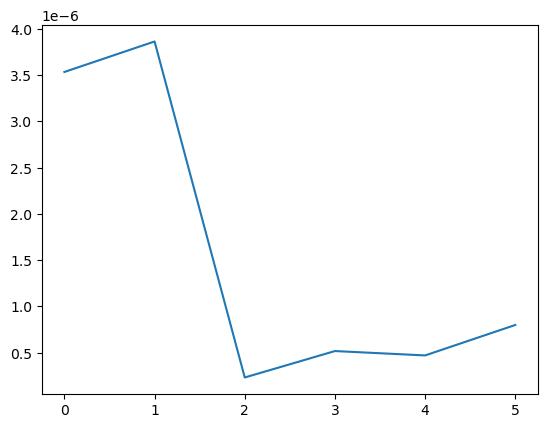

In [34]:
model_baseline = MLP(q_p.shape[1])

train(model=model_baseline, x=q_p, dx=dq_dp, batch_size=32, epochs=50, baseline=True, lr=1e-3)

# HNN

 17%|█▋        | 1/6 [00:52<04:24, 52.98s/it]

Epoch 0/5 --- Train-Loss: 6.366489287756849e-06


 33%|███▎      | 2/6 [01:45<03:31, 52.81s/it]

Epoch 1/5 --- Train-Loss: 1.8977907245698589e-07


 50%|█████     | 3/6 [02:40<02:41, 53.89s/it]

Epoch 2/5 --- Train-Loss: 3.1342335660156095e-07


 67%|██████▋   | 4/6 [03:28<01:43, 51.55s/it]

Epoch 3/5 --- Train-Loss: 5.093776849207643e-07


 83%|████████▎ | 5/6 [04:20<00:51, 51.62s/it]

Epoch 4/5 --- Train-Loss: 1.0681020512492978e-07


100%|██████████| 6/6 [05:13<00:00, 52.33s/it]

Epoch 5/5 --- Train-Loss: 1.6871480568170227e-07


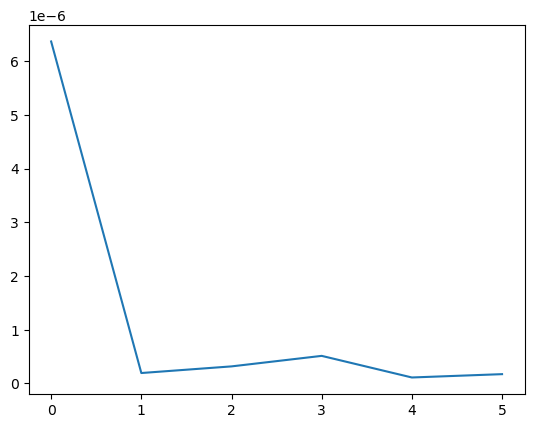

In [36]:
model_HNN = MLP(q_p.shape[1])

train(model=model_HNN, x=q_p, dx=dq_dp, batch_size=32, epochs=50, baseline=False, lr=1e-3)

# Predicting

In [37]:
q_p0 = q_p[0].detach().numpy()
t_span = [0, 1000]
steps = 10000

# integrate
t = torch.linspace(t_span[0], t_span[1], steps)
xHNN = integrate_model(model_HNN.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=False)
xBaseline = integrate_model(model_baseline.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=True)

In [38]:
HNN_data = reshape_data(xHNN.y)
Baseline_data = reshape_data(xBaseline.y)

# Plot the results
## HNN

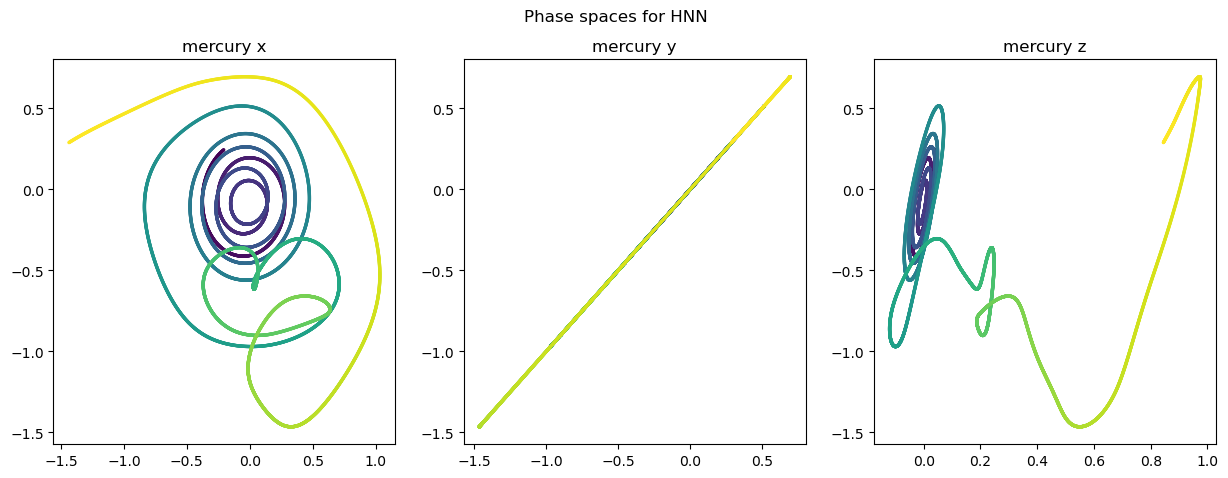

In [40]:
plot_phase_space(HNN_data, target_names, "Phase spaces for HNN")

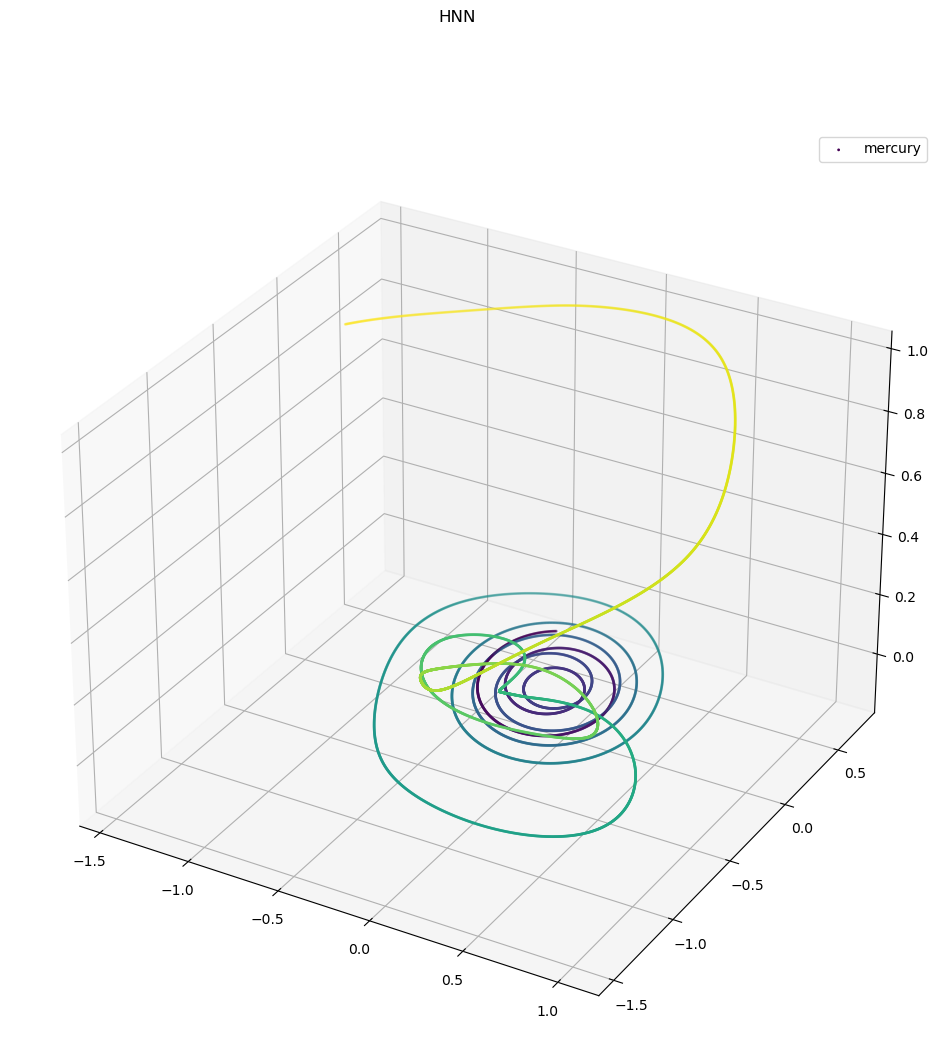

In [41]:
plot_space(HNN_data, target_names, "HNN", color=True)

## Baseline NN

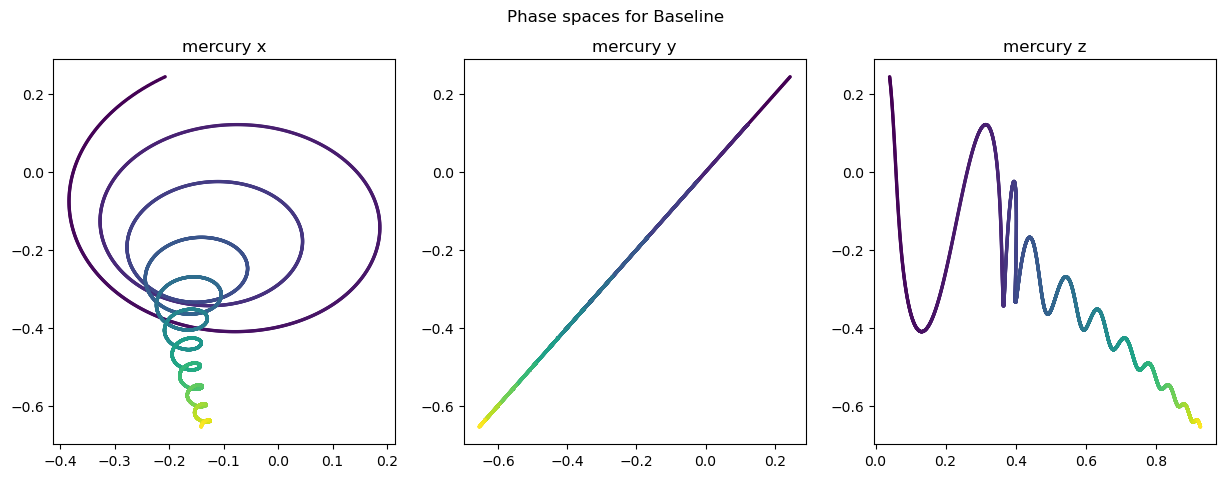

In [42]:
plot_phase_space(Baseline_data, target_names, "Phase spaces for Baseline")

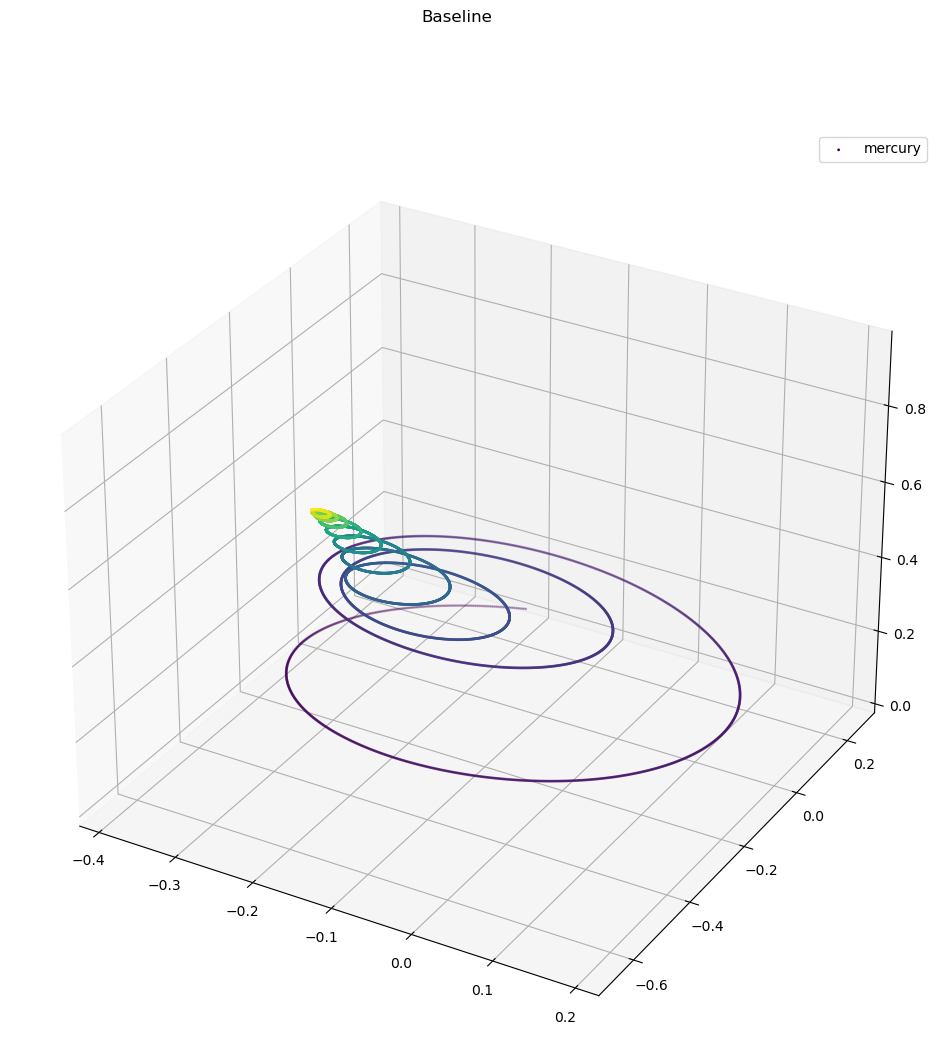

In [43]:
plot_space(Baseline_data, target_names, "Baseline", color=True)

# Plot Hamiltonian

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


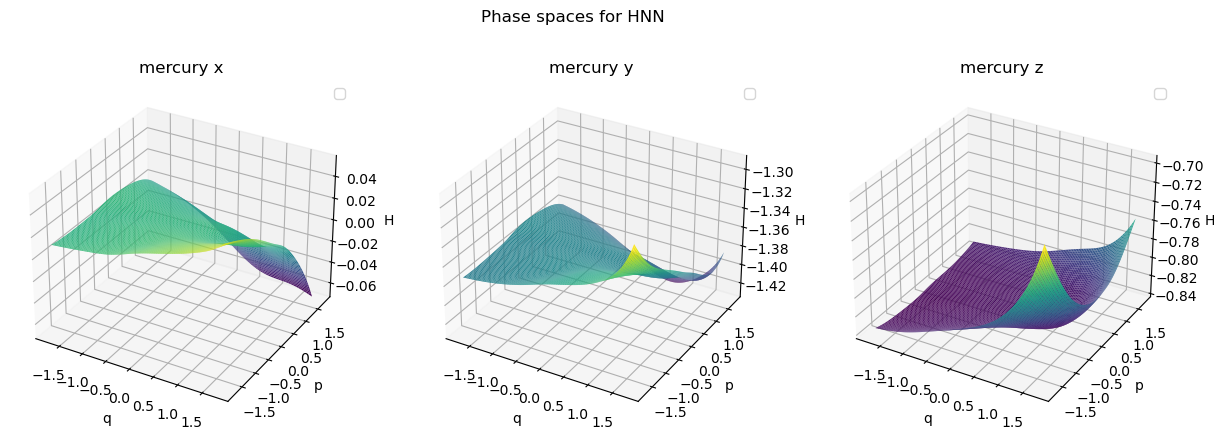

In [115]:
plot_phase_space_HM(HNN_data, target_names, "Phase spaces for HNN", model_HNN)